In [2]:
import sklearn.datasets
import urllib.request
import os.path

import numpy as np
import matplotlib.pyplot as plt

from optimizer.loss import LogisticRegression
from optimizer.cubic import Cubic_LS, Cubic_Krylov_LS, SSCN

In [3]:
# Loading the dataset
# dataset = 'rcv1_train.binary'
dataset = 'news20.binary'

data_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/{}".format(dataset)

if dataset in {'gisette_scale','duke','rcv1_train.binary','news20.binary'}:
    data_path = './{}.bz2'.format(dataset)
else:
    data_path = './{}'.format(dataset)
if not os.path.exists(data_path):
    f = urllib.request.urlretrieve(data_url, data_path)
A, b = sklearn.datasets.load_svmlight_file(data_path)
# A = A.toarray()

# Converting A into the Compressed Sparse Column (CSC) format; this is particularly suitable for SSCN
A_csc = A.tocsc()

In [4]:
print(A.shape)

(19996, 1355191)


In [5]:
# Define loss functions
loss = LogisticRegression(A, b, l1=0, l2=0, store_mat_vec_prod=True)
loss_csc = LogisticRegression(A_csc, b, l1=0, l2=0, store_mat_vec_prod=True)
n, dim = A.shape
x0 = np.ones(dim) * 0.5

# Set the max iteration and time
it_max = 50
t_max = 600000

In [6]:
memory_size = 10
memory_size_bench = 20
reg_coef = 1e-3

cub_krylov = Cubic_Krylov_LS(loss=loss, reg_coef= reg_coef, label='Krylov Cubic Newton (m = {})'.format(memory_size),
                               subspace_dim=memory_size, tolerance = 1e-9)

# cub_krylov_bench is used to compute the optimal value of the function
cub_krylov_bench = Cubic_Krylov_LS(loss=loss, reg_coef= reg_coef, label='Krylov Cubic Newton (m = {})'.format(memory_size_bench),
                               subspace_dim=memory_size_bench, tolerance = 1e-9)

if dim < 500:
    cubic_solver = "full"
else:
    cubic_solver = "CG"

cub_root = Cubic_LS(loss=loss, reg_coef=reg_coef, cubic_solver=cubic_solver, label='Cubic Newton', tolerance = 1e-8)

sscn = SSCN(loss=loss_csc, reg_coef = reg_coef, label='SSCN (m = {})'.format(memory_size),
                               subspace_dim=memory_size, tolerance = 1e-9)

In [7]:
print(f'Running optimizer: {cub_root.label}')
cub_root.run(x0=x0, it_max=it_max, t_max=t_max)
cub_root.compute_loss_of_iterates()

Running optimizer: Cubic Newton


 78%|███████▊  | 39/50 [10:58<03:05, 16.88s/it]


In [8]:
t_max = max(cub_root.trace.ts[-1],t_max)

In [9]:
print(f'Running optimizer: {sscn.label}')
sscn.run(x0=x0, it_max=it_max, t_max=t_max)
sscn.compute_loss_of_iterates()

Running optimizer: SSCN (m = 10)


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 92.75it/s]


In [10]:
sscn50 = SSCN(loss=loss_csc, reg_coef = 1e-3, label='SSCN (m = {})'.format(50),
                               subspace_dim=50, tolerance = 1e-9)

sscn100 = SSCN(loss=loss_csc, reg_coef = 1e-3, label='SSCN (m = {})'.format(100),
                               subspace_dim=100, tolerance = 1e-9)

sscn500 = SSCN(loss=loss_csc, reg_coef = 1e-3, label='SSCN (m = {})'.format(500),
                               subspace_dim=500, tolerance = 1e-9)

print(f'Running optimizer: {sscn50.label}')
sscn50.run(x0=x0, it_max=it_max, t_max=t_max)
sscn50.compute_loss_of_iterates()

print(f'Running optimizer: {sscn100.label}')
sscn100.run(x0=x0, it_max=it_max, t_max=t_max)
sscn100.compute_loss_of_iterates()

print(f'Running optimizer: {sscn500.label}')
sscn500.run(x0=x0, it_max=it_max, t_max=t_max)
sscn500.compute_loss_of_iterates()

Running optimizer: SSCN (m = 50)


100%|██████████| 50/50 [00:00<00:00, 103.80it/s]


Running optimizer: SSCN (m = 100)


100%|██████████| 50/50 [00:00<00:00, 74.97it/s]


Running optimizer: SSCN (m = 500)


100%|██████████| 50/50 [00:01<00:00, 48.47it/s]


In [11]:
sscn1000 = SSCN(loss=loss_csc, reg_coef = 1e-3, label='SSCN (m = {})'.format(1000),
                               subspace_dim=1000, tolerance = 1e-9)

sscn5000 = SSCN(loss=loss_csc, reg_coef = 1e-3, label='SSCN (m = {})'.format(5000),
                               subspace_dim=5000, tolerance = 1e-9)

print(f'Running optimizer: {sscn1000.label}')
sscn1000.run(x0=x0, it_max=it_max, t_max=t_max)
sscn1000.compute_loss_of_iterates()

# print(f'Running optimizer: {sscn5000.label}')
# sscn5000.run(x0=x0, it_max=it_max, t_max=t_max)
# sscn5000.compute_loss_of_iterates()

Running optimizer: SSCN (m = 1000)


100%|██████████| 50/50 [00:02<00:00, 19.35it/s]


In [12]:
print(f'Running optimizer: {cub_krylov.label}')
cub_krylov.run(x0=x0, it_max=it_max, t_max=t_max)
cub_krylov.compute_loss_of_iterates()

print(f'Running optimizer: {cub_krylov_bench.label}')
cub_krylov_bench.run(x0=x0, it_max=5*it_max, t_max=5*t_max)
cub_krylov_bench.compute_loss_of_iterates()

Running optimizer: Krylov Cubic Newton (m = 10)


100%|██████████| 50/50 [00:18<00:00,  2.71it/s]


Running optimizer: Krylov Cubic Newton (m = 20)


100%|██████████| 250/250 [02:04<00:00,  2.01it/s]


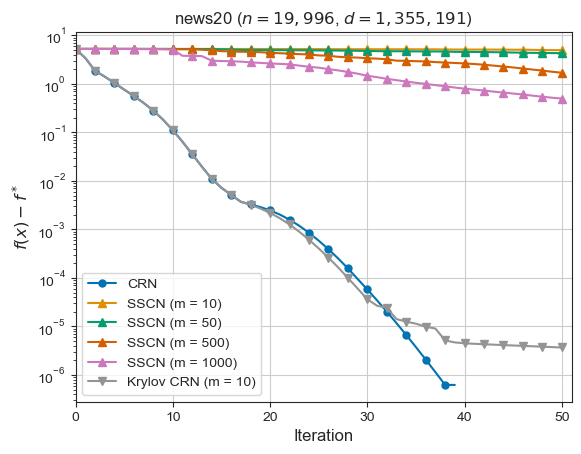

In [16]:
import seaborn as sns 

sns.set_style('ticks') # setting style
# sns.set_context('paper') # setting context
sns.set_palette('colorblind') # setting palette

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# flag_time = True
flag_time = False

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

f_opt = min(loss.f_opt, loss_csc.f_opt)

cub_root.trace.plot_losses(marker='o', markersize=5, f_opt=f_opt, time=flag_time, label='CRN')

sscn.trace.plot_losses(marker='^', markersize=6, f_opt=f_opt, time=flag_time)
sscn50.trace.plot_losses(marker='^', markersize=6, f_opt=f_opt, time=flag_time)

# sscn100.trace.plot_losses(marker='^', markersize=6, f_opt=f_opt, time=flag_time)
sscn500.trace.plot_losses(marker='^', markersize=6, f_opt=f_opt, time=flag_time)
sscn1000.trace.plot_losses(marker='^', markersize=6, f_opt=f_opt, time=flag_time)
# sscn5000.trace.plot_losses(marker='^', time=flag_time)

cub_krylov.trace.plot_losses(marker='v', markersize=6, f_opt=f_opt, color = color_cycle[7], time=flag_time, label='Krylov CRN (m = 10)')


# cub_root.trace.plot_losses(marker='*', label='cubic Newton (exact)')
# plt.xscale('log')
# print(cub.trace.loss_vals)
plt.yscale('log')
# plt.ylim(1e-9,10)

plt.legend()
plt.grid()

plt.title('{} ($n={:,}$, $d={:,}$)'.format(dataset,n,dim))
if flag_time: 
    plt.xlim(0,70)
    plt.xlabel('Time (s)')
    plt.savefig('figs/time_{}.pdf'.format(dataset))   
else:
    plt.xlim(0,it_max+1)
    plt.xlabel('Iteration')
    plt.savefig('figs/iteration_{}.pdf'.format(dataset))
plt.show()
